# Analysis of the Causes of Aircraft Crashes by NLP

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import re
import string

from wordcloud import WordCloud

import nltk

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download("punkt")

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer,TfidfVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

stop_words = stopwords.words('english')
lem = WordNetLemmatizer()

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Alp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Alp\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Alp\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
df1 = pd.read_csv('Airplane_Crashes_and_Fatalities_Since_1908.csv')

In [3]:
df1.head(5)

Date   Time                            Location  \
0  09/17/1908  17:18                 Fort Myer, Virginia   
1  07/12/1912  06:30             AtlantiCity, New Jersey   
2  08/06/1913    NaN  Victoria, British Columbia, Canada   
3  09/09/1913  18:30                  Over the North Sea   
4  10/17/1913  10:30          Near Johannisthal, Germany   

                 Operator Flight #          Route                    Type  \
0    Military - U.S. Army      NaN  Demonstration        Wright Flyer III   
1    Military - U.S. Navy      NaN    Test flight               Dirigible   
2                 Private        -            NaN        Curtiss seaplane   
3  Military - German Navy      NaN            NaN  Zeppelin L-1 (airship)   
4  Military - German Navy      NaN            NaN  Zeppelin L-2 (airship)   

  Registration cn/In  Aboard  Fatalities  Ground  \
0          NaN     1     2.0         1.0     0.0   
1          NaN   NaN     5.0         5.0     0.0   
2          NaN   NaN     1.0         1.0     0.0   
3          NaN   NaN    20.0        14.0     0.0   
4          NaN   NaN    30.0        30.0     0.0   

                                             Summary  
0  During a demonstration flight, a U.S. Army fly...  
1  First U.S. dirigible Akron exploded just offsh...  
2  The first fatal airplane accident in Canada oc...  
3  The airship flew into a thunderstorm and encou...  
4  Hydrogen gas which was being vented was sucked...

In [4]:
df1['hour'] = df1['Time'].astype(str).str[0:2]

In [5]:
df1.sample(5)

Date   Time                   Location  \
1615  08/27/1959    NaN    Near Asuncion, Paraguay   
1834  02/03/1963  12:07  San Francisco, California   
1157  10/22/1951    NaN         Skopje, Yugoslavia   
318   02/23/1934  02:00  Near Salt Lake City, Utah   
4876  07/28/2002  15:25             Moscow, Russia   

                         Operator Flight #                      Route  \
1615        Aerolineas Argentinas      NaN                        NaN   
1834                Slick Airways       40                        NaN   
1157        JAT Yugoslav Airlines      NaN           Belgrad - Skopje   
318       Boeing Aircraft Company      NaN  Salt Lake City - Cheyenne   
4876  Pulkovo Aviation Enterprise      NaN   Moscow - St. Petersburgh   

                                    Type Registration        cn/In  Aboard  \
1615         de Havilland DH-106 Comet 4       LV-AHP         6411    50.0   
1834  Lockheed 1049H Super Constellation       N9740Z         4851     8.0   
1157                        Douglas DC-3       YU-ACC        13014    12.0   
318                           Boeing 247      NC13357         1739     8.0   
4876                      Iluyshin Il-86     RA-86060  51483203027    16.0   

      Fatalities  Ground                                            Summary  \
1615         2.0     0.0  The aircraft descended below MDA and crashed 5...   
1834         3.0     0.0  The aircraft struck approach lights 1,170 feet...   
1157        12.0     0.0                            Crashed while en route.   
318          8.0     0.0  Crashed on top of Parley's canyon, 20 miles fr...   
4876        14.0     0.0  A Russian passenger airliner on a training fli...   

     hour  
1615   na  
1834   12  
1157   na  
318    02  
4876   15

In [6]:
df1.isnull().sum()

Date               0
Time            2219
Location          20
Operator          18
Flight #        4199
Route           1706
Type              27
Registration     335
cn/In           1228
Aboard            22
Fatalities        12
Ground            22
Summary          390
hour               0
dtype: int64

In [7]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5268 entries, 0 to 5267
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          5268 non-null   object 
 1   Time          3049 non-null   object 
 2   Location      5248 non-null   object 
 3   Operator      5250 non-null   object 
 4   Flight #      1069 non-null   object 
 5   Route         3562 non-null   object 
 6   Type          5241 non-null   object 
 7   Registration  4933 non-null   object 
 8   cn/In         4040 non-null   object 
 9   Aboard        5246 non-null   float64
 10  Fatalities    5256 non-null   float64
 11  Ground        5246 non-null   float64
 12  Summary       4878 non-null   object 
 13  hour          5268 non-null   object 
dtypes: float64(3), object(11)
memory usage: 576.3+ KB


In [8]:
df1.shape

(5268, 14)

In [9]:
df1['hour'] = df1['Time'].astype(str).str[0:2]

In [10]:
df = df1[['Summary', 'Type', 'Operator', 'Location', 'Date', 'hour']]

In [11]:
df.sample(5)

Summary  \
2417                     Shot down by a rocket grenade.   
3450  Witnesses observed what appeared to be a norma...   
745   Crashed and burned after experiencing an engin...   
2329  Crash landed while attempting an emergency lan...   
2907  The plane was hijacked ,in Athens, by Palestin...   

                                  Type                   Operator  \
2417  Boeing Vertol CH47B (helicopter)       Military - U.S. Army   
3450                  Beechcraft B-100                   Air Taxi   
745                     Short Stirling  Military -Royal Air Force   
2329  Sud Aviation SE-210 Caravelle 6N                Air Algerie   
2907                       Airbus A300                 Air France   

                        Location        Date hour  
2417  Near Tam Ky, South Vietnam  08/26/1970   na  
3450              Midland, Texas  11/26/1983   15  
745           Near Castel, Libya  11/11/1945   23  
2329             Biskra, Algeria  07/26/1969   na  
2907             Entebbe, Uganda  06/27/1976   na

In [12]:
df.Operator.value_counts()

Aeroflot                     179
Military - U.S. Air Force    176
Air France                    70
Deutsche Lufthansa            65
United Air Lines              44
                            ... 
Aeronaves del Peru             1
Ace Flying Service             1
MerriAviation - Air Taxi       1
Air West                       1
Canair Corp. - Air Taxi        1
Name: Operator, Length: 2476, dtype: int64

In [13]:
df.Type.value_counts()

Douglas DC-3                                334
de Havilland Canada DHC-6 Twin Otter 300     81
Douglas C-47A                                74
Douglas C-47                                 62
Douglas DC-4                                 40
                                           ... 
Nord 262                                      1
Aerospatiale SN-601 Corvette                  1
Pilatus PC6CH2                                1
Shorts SC.7 Skyvan 3-100                      1
Airbus A-310-324ET                            1
Name: Type, Length: 2446, dtype: int64

In [14]:
df.Location.value_counts()

Sao Paulo, Brazil              15
Moscow, Russia                 15
Rio de Janeiro, Brazil         14
Manila, Philippines            13
Bogota, Colombia               13
                               ..
Walshville, Illinois            1
BaltiSea                        1
Sverdlovsk, Russia              1
Ust-Orda, Russia                1
Off Montauk Point, New York     1
Name: Location, Length: 4303, dtype: int64

In [15]:
df['year'] = df.Date.str.extract(r'([0-9][0-9][0-9][0-9])', expand=True)

In [16]:
df.head(2)

Summary              Type  \
0  During a demonstration flight, a U.S. Army fly...  Wright Flyer III   
1  First U.S. dirigible Akron exploded just offsh...         Dirigible   

               Operator                 Location        Date hour  year  
0  Military - U.S. Army      Fort Myer, Virginia  09/17/1908   17  1908  
1  Military - U.S. Navy  AtlantiCity, New Jersey  07/12/1912   06  1912

In [17]:
df.tail(2)

Summary  \
5266  The air ambulance crashed into hills while att...   
5267  The military transport went missing while en r...   

                                  Type                     Operator  \
5266  Britten-Norman BN-2A-27 Islander                   Strait Air   
5267                     Antonov An-32  Military - Indian Air Force   

                                          Location        Date hour  year  
5266  Near Port Hope Simpson, Newfoundland, Canada  06/07/2009   08  2009  
5267             State of Arunachal Pradesh, India  06/08/2009   na  2009

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5268 entries, 0 to 5267
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Summary   4878 non-null   object
 1   Type      5241 non-null   object
 2   Operator  5250 non-null   object
 3   Location  5248 non-null   object
 4   Date      5268 non-null   object
 5   hour      5268 non-null   object
 6   year      5268 non-null   object
dtypes: object(7)
memory usage: 288.2+ KB


In [19]:
df.shape

(5268, 7)

In [20]:
df['year'] = df['year'].astype(str).astype(int)

In [21]:
df = df[df['year'] >= 1969]

In [22]:
df.shape

(2994, 7)

In [23]:
df.head()

Summary                      Type  \
1237                                 NaN                Cessna 402   
1643                                 NaN           Ilyushin IL-18B   
1807  Crashed while approaching to land.    de Havilland DH-125-1A   
1965            Crashed into a mountain.  Lockheed C-130E Hercules   
2003                                 NaN              Douglas C-47   

                          Operator                  Location        Date hour  \
1237                     Avia-Taxi    Pin-la-Garenne, France  02/13/1970   na   
1643                      Aeroflot  Near Semipalatinsk, USSR  05/11/1973   na   
1807              Avionas  Banamex          Acapulco, Mexico  10/12/1973   na   
1965     Military - U.S. Air Force  Fort Smith AFB, Oklahoma  10/15/1973   na   
2003  Military - Chilian Air Force           Santiago, Chili  07/31/1975   na   

      year  
1237  1970  
1643  1973  
1807  1973  
1965  1973  
2003  1975

In [24]:
df = df[df['Summary'].notna()]

In [25]:
df.shape

(2892, 7)

**Text Mining**

In [26]:
def cleaning(data):
    
    #1. Tokenize
    text_tokens = word_tokenize(data.lower())   #removed the .lower intentionaly to keep NNP s
    
    #2. Remove Puncs
    tokens_without_punc = [w for w in text_tokens if w.isalpha()]
    
    #3. Removing Stopwords
    tokens_without_sw = [t for t in tokens_without_punc if t not in stop_words]
    
    #4. lemma
    text_cleaned = [lem.lemmatize(t) for t in tokens_without_sw]
    
    #joining
    return " ".join(text_cleaned)

In [27]:
df['Summary'] = df['Summary'].apply(cleaning)

In [123]:
df.head()

Summary                      Type  \
1807              crashed approaching land    de Havilland DH-125-1A   
1965                      crashed mountain  Lockheed C-130E Hercules   
2077        crashed high ground descending             Antonov AN-24   
2243     cargo plane went missing en route              Douglas DC-4   
2279  crashed short runway attempting land  Lockheed C-130E Hercules   

                       Operator                     Location        Date hour  \
1807           Avionas  Banamex             Acapulco, Mexico  10/12/1973   na   
1965  Military - U.S. Air Force     Fort Smith AFB, Oklahoma  10/15/1973   na   
2077                   Aeroflot  Near Sukhumi, Georgia, USSR  11/17/1975   na   
2243  Continental Air Transport                 AtlantiOcean  03/08/1969   na   
2279  Military - U.S. Air Force  Ching Chuan Kang AB, Taiwan  03/08/1969   na   

      year  
1807  1973  
1965  1973  
2077  1975  
2243  1969  
2279  1969

**WordCloud - Report**

In [29]:
reports =[]

for review in df.Summary:
    reports.append(review) 
reports = ' '.join(reports)
reports[:200]

'crashed approaching land crashed mountain crashed high ground descending cargo plane went missing en route crashed short runway attempting land crashed pilot experienced spatial disorientation whiteou'

In [30]:
len(reports)

433242

In [31]:
from wordcloud import WordCloud

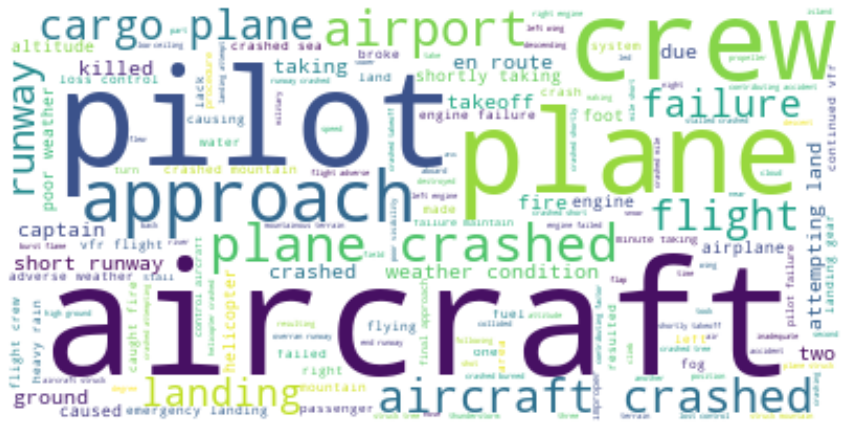

In [33]:
wordcloud = WordCloud(background_color="white", max_words=len(reports))

wordcloud.generate(reports)

plt.figure(figsize=(15,15))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [120]:
type(wordcloud)

wordcloud.wordcloud.WordCloud

In [34]:
wordcloud.to_file("WC_air_summary1.png")

In [43]:
#remove 3 too obvious words

In [36]:
reports = reports.replace('plane', '')

In [37]:
reports = reports.replace('aircraft', '')

In [38]:
reports = reports.replace('crashed', '')

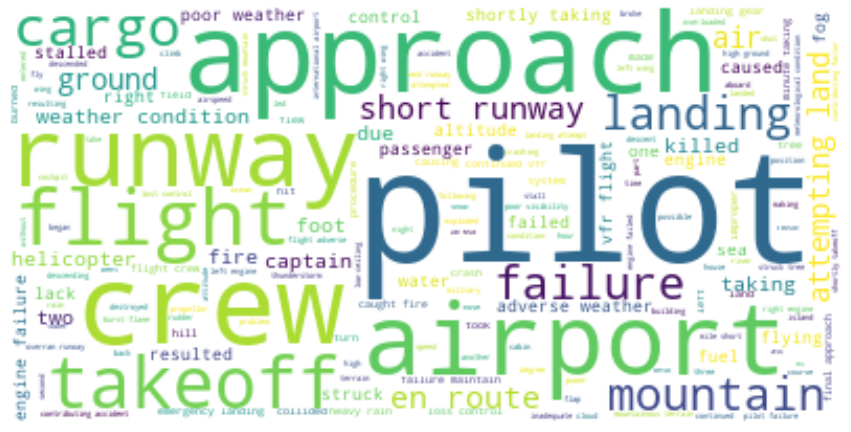

In [40]:
wordcloud = WordCloud(background_color="white", max_words=len(reports))

wordcloud.generate(reports)

plt.figure(figsize=(15,15))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [41]:
wordcloud.to_file("WC_air_summary2_aircraft-plane-crashed.png")

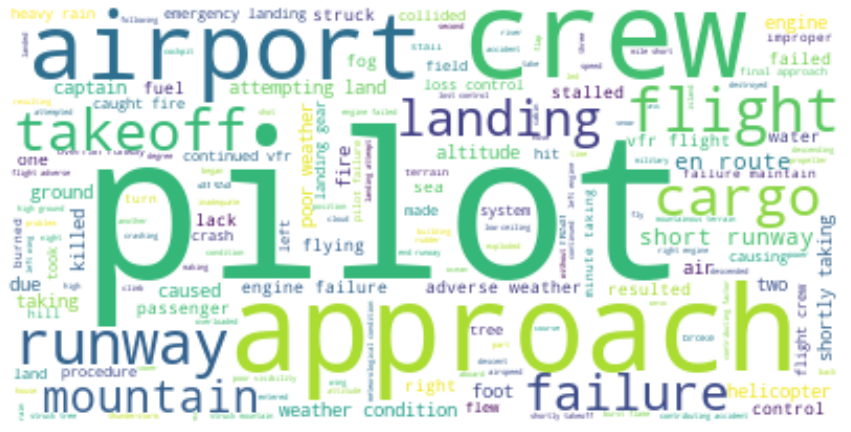

In [44]:
wordcloud = WordCloud(background_color="white", max_words=500)

wordcloud.generate(reports)

plt.figure(figsize=(15,15))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [45]:
wordcloud.to_file("WC_air_summary3_aircraft-plane-crashed-500words.png")

In [121]:
from collections import Counter
most_common_words = Counter(" ".join(df["Summary"]).split()).most_common(20)
most_common_words

[('crashed', 1926),
 ('aircraft', 1515),
 ('plane', 1282),
 ('pilot', 877),
 ('flight', 743),
 ('runway', 692),
 ('engine', 673),
 ('approach', 620),
 ('crew', 615),
 ('failure', 585),
 ('landing', 475),
 ('airport', 442),
 ('mountain', 400),
 ('weather', 392),
 ('condition', 362),
 ('control', 359),
 ('taking', 357),
 ('altitude', 355),
 ('takeoff', 351),
 ('land', 337)]

In [ ]:
reports = reports.replace('crashed', '')
reports = reports.replace('aircraft', '')
reports = reports.replace('plane', '')

In [119]:
plt.figure(figsize=(15,10))
most_common_words.size().sort_values(ascending=False).plot.bar()
plt.xticks(rotation=50)
plt.xlabel("Country of Origin")
plt.ylabel("Number of Wines")
plt.show()

AttributeError: 'list' object has no attribute 'sort_values'

<Figure size 1080x720 with 0 Axes>

**WordCloud - Operator**

In [46]:
df.head()

Summary                      Type  \
1807              crashed approaching land    de Havilland DH-125-1A   
1965                      crashed mountain  Lockheed C-130E Hercules   
2077        crashed high ground descending             Antonov AN-24   
2243     cargo plane went missing en route              Douglas DC-4   
2279  crashed short runway attempting land  Lockheed C-130E Hercules   

                       Operator                     Location        Date hour  \
1807           Avionas  Banamex             Acapulco, Mexico  10/12/1973   na   
1965  Military - U.S. Air Force     Fort Smith AFB, Oklahoma  10/15/1973   na   
2077                   Aeroflot  Near Sukhumi, Georgia, USSR  11/17/1975   na   
2243  Continental Air Transport                 AtlantiOcean  03/08/1969   na   
2279  Military - U.S. Air Force  Ching Chuan Kang AB, Taiwan  03/08/1969   na   

      year  
1807  1973  
1965  1973  
2077  1975  
2243  1969  
2279  1969

In [59]:
Ops =[]

for i in df.Operator:
    Ops.append(i) 
Ops = ''.join(str(Ops))
Ops[:200]

"['Avionas  Banamex', 'Military - U.S. Air Force', 'Aeroflot', 'Continental Air Transport', 'Military - U.S. Air Force', 'Wien Consolidated Airlines', 'China Airlines (Taiwan)', 'ERA Helicopter', 'Aria"

In [60]:
Ops = Ops.replace('Airlines', '')

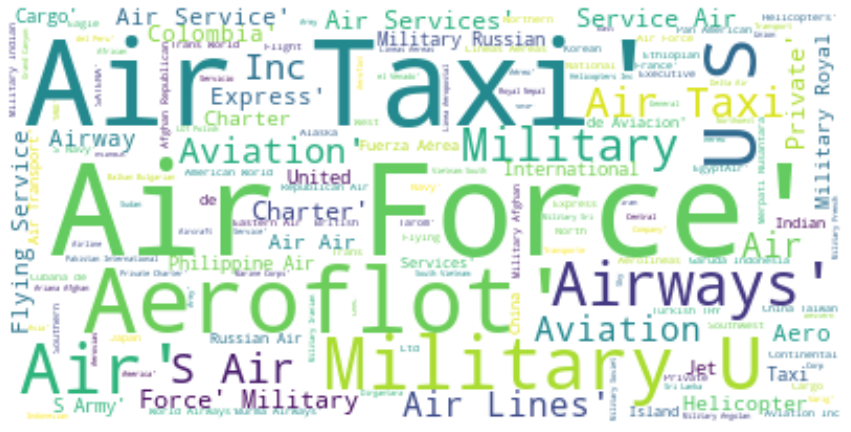

In [61]:
wordcloud = WordCloud(background_color="white", max_words=len(Ops))

wordcloud.generate(Ops)

plt.figure(figsize=(15,15))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [62]:
len(Ops)

63451

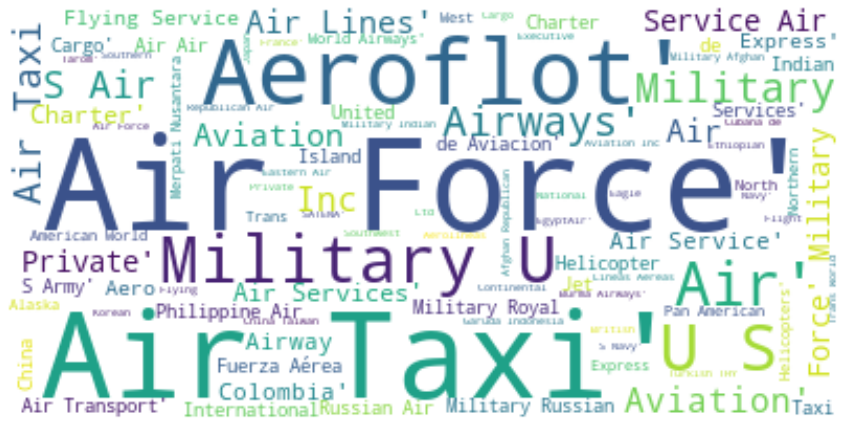

In [64]:
wordcloud = WordCloud(background_color="white", max_words=1000)

wordcloud.generate(Ops)

plt.figure(figsize=(15,15))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [65]:
wordcloud.to_file("WC_Operator1_Airlines-1000words.png")

**WordCloud - Type**

In [66]:
df.head()

Summary                      Type  \
1807              crashed approaching land    de Havilland DH-125-1A   
1965                      crashed mountain  Lockheed C-130E Hercules   
2077        crashed high ground descending             Antonov AN-24   
2243     cargo plane went missing en route              Douglas DC-4   
2279  crashed short runway attempting land  Lockheed C-130E Hercules   

                       Operator                     Location        Date hour  \
1807           Avionas  Banamex             Acapulco, Mexico  10/12/1973   na   
1965  Military - U.S. Air Force     Fort Smith AFB, Oklahoma  10/15/1973   na   
2077                   Aeroflot  Near Sukhumi, Georgia, USSR  11/17/1975   na   
2243  Continental Air Transport                 AtlantiOcean  03/08/1969   na   
2279  Military - U.S. Air Force  Ching Chuan Kang AB, Taiwan  03/08/1969   na   

      year  
1807  1973  
1965  1973  
2077  1975  
2243  1969  
2279  1969

In [67]:
Tip =[]

for i in df.Type:
    Tip.append(i) 
Tip = ''.join(str(Tip))
Tip[:200]

"['de Havilland DH-125-1A', 'Lockheed C-130E Hercules', 'Antonov AN-24', 'Douglas DC-4', 'Lockheed C-130E Hercules', 'de Havilland DHC-6', 'Douglas DC-3D', 'Bell 205A', 'Boeing B-727-113C', 'Convair CV"

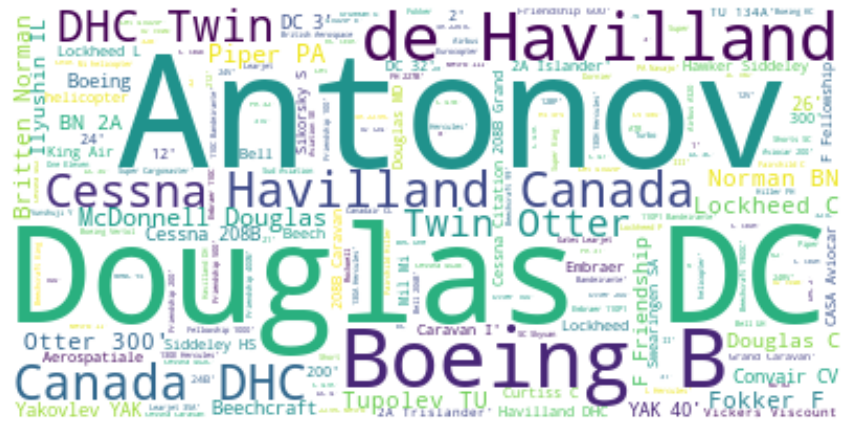

In [68]:
wordcloud = WordCloud(background_color="white", max_words=len(Tip))

wordcloud.generate(Tip)

plt.figure(figsize=(15,15))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [69]:
len(Tip)

67557

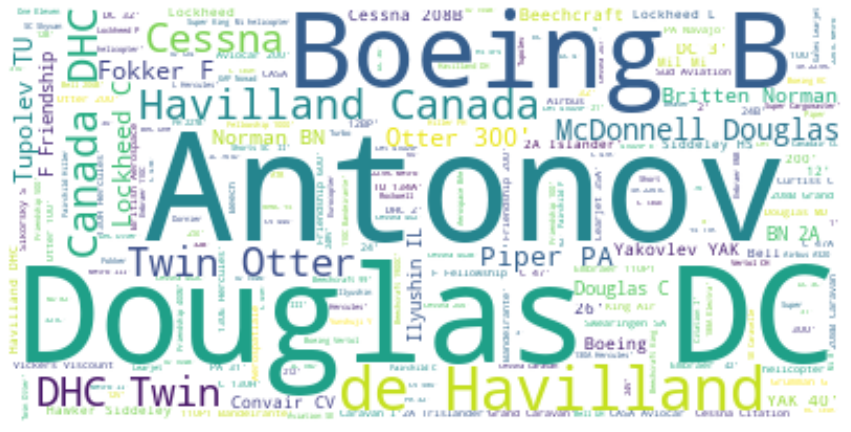

In [70]:
wordcloud = WordCloud(background_color="white", max_words=500)

wordcloud.generate(Tip)

plt.figure(figsize=(15,15))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [71]:
wordcloud.to_file("WC_Type1_Airlines-500words.png")

**WordCloud - Location**

In [72]:
Pl =[]

for i in df.Location:
    Pl.append(i) 
Pl = ''.join(str(Pl))
Pl[:200]

"['Acapulco, Mexico', 'Fort Smith AFB, Oklahoma', 'Near Sukhumi, Georgia, USSR', 'AtlantiOcean', 'Ching Chuan Kang AB, Taiwan', 'Minchumina, Alaska', 'Mt. Paku, Taiwan', 'Tyonek, Alaska', 'Gatwick Airp"

In [73]:
Pl = Pl.replace('Near', '')

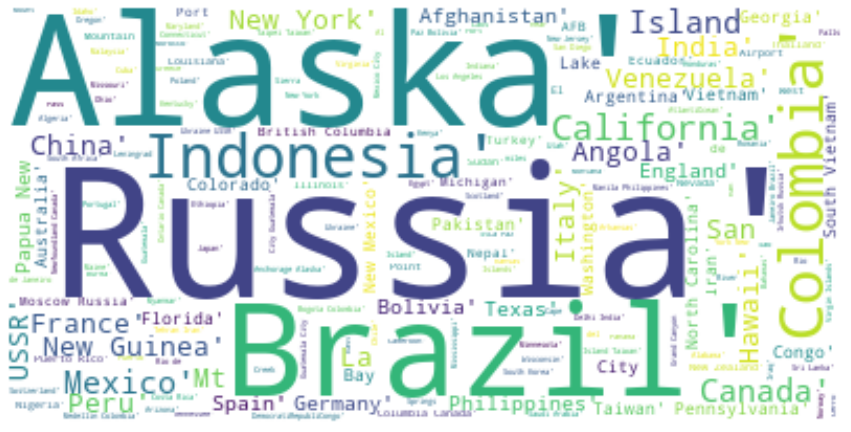

In [74]:
wordcloud = WordCloud(background_color="white", max_words=len(Pl))

wordcloud.generate(Pl)

plt.figure(figsize=(15,15))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [75]:
len(Pl)

68105

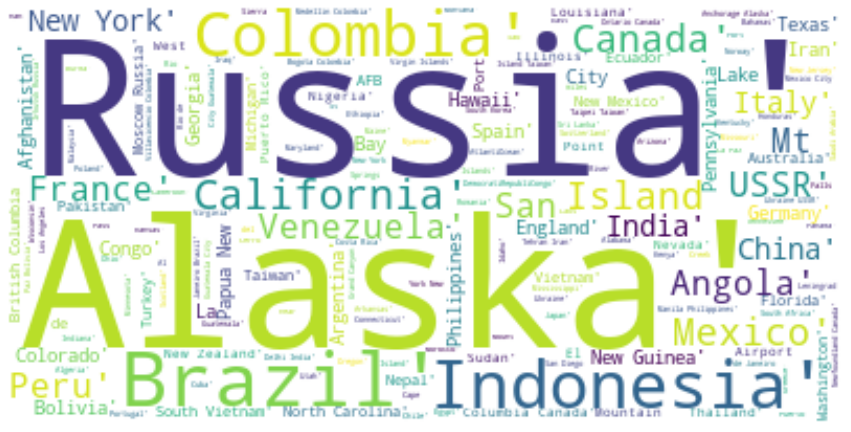

In [76]:
wordcloud = WordCloud(background_color="white", max_words=500)

wordcloud.generate(Pl)

plt.figure(figsize=(15,15))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

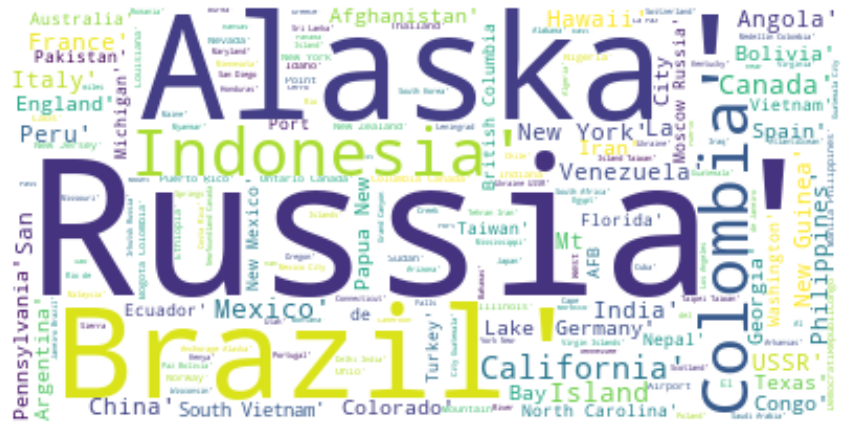

In [77]:
wordcloud = WordCloud(background_color="white", max_words=1000)

wordcloud.generate(Pl)

plt.figure(figsize=(15,15))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [78]:
wordcloud.to_file("WC_Location-Near-1000words.png")

**WordCloud - Year**

In [79]:
df.head()

Summary                      Type  \
1807              crashed approaching land    de Havilland DH-125-1A   
1965                      crashed mountain  Lockheed C-130E Hercules   
2077        crashed high ground descending             Antonov AN-24   
2243     cargo plane went missing en route              Douglas DC-4   
2279  crashed short runway attempting land  Lockheed C-130E Hercules   

                       Operator                     Location        Date hour  \
1807           Avionas  Banamex             Acapulco, Mexico  10/12/1973   na   
1965  Military - U.S. Air Force     Fort Smith AFB, Oklahoma  10/15/1973   na   
2077                   Aeroflot  Near Sukhumi, Georgia, USSR  11/17/1975   na   
2243  Continental Air Transport                 AtlantiOcean  03/08/1969   na   
2279  Military - U.S. Air Force  Ching Chuan Kang AB, Taiwan  03/08/1969   na   

      year  
1807  1973  
1965  1973  
2077  1975  
2243  1969  
2279  1969

In [80]:
# sayilarda problem oldugu icin alternatif yontem

In [81]:
counts = df['year'].value_counts()

In [82]:
counts.index = counts.index.map(str)

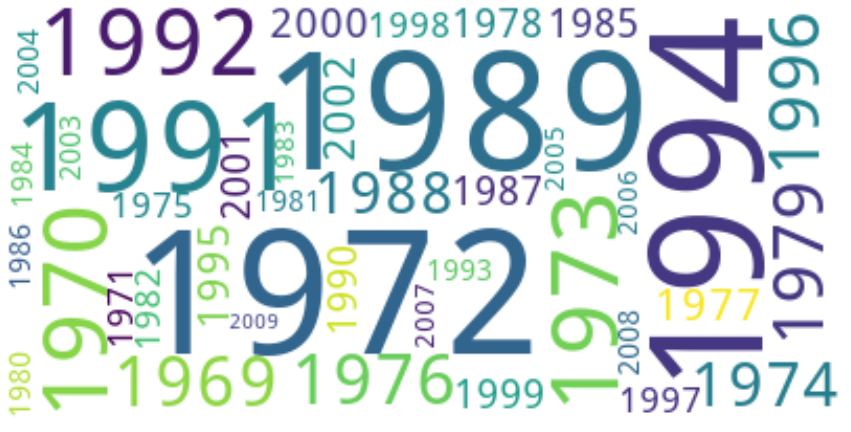

In [83]:
wordcloud = WordCloud(background_color="white").generate_from_frequencies(counts)
plt.figure(figsize=(15,15))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [84]:
len(counts)

41

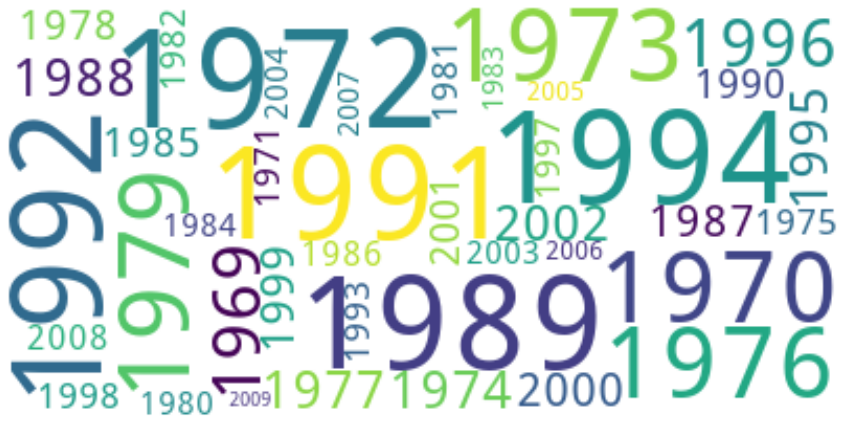

In [85]:
wordcloud = WordCloud(background_color="white", max_words=1000).generate_from_frequencies(counts)
plt.figure(figsize=(15,15))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

**WordCloud - Hour of the Day**

In [86]:
dfh = df[['year', 'hour']]
dfh

year hour
1807  1973   na
1965  1973   na
2077  1975   na
2243  1969   na
2279  1969   na
...    ...  ...
5263  2009   06
5264  2009   na
5265  2009   00
5266  2009   08
5267  2009   na

[2892 rows x 2 columns]

In [87]:
dfh = dfh[dfh['hour'].notna()]

In [103]:
dfh.hour.value_counts()

19    131
09    128
11    123
15    121
14    118
12    118
13    112
16    110
10    104
18     98
08     96
17     96
20     93
07     91
21     66
22     64
23     61
06     57
00     34
05     33
04     30
02     29
01     29
03     24
Name: hour, dtype: int64

In [104]:
dfh.drop(dfh[dfh['hour'] == 'c1'].index, inplace = True) 

In [105]:
counts = dfh['hour'].value_counts()

In [106]:
counts.index = counts.index.map(str)

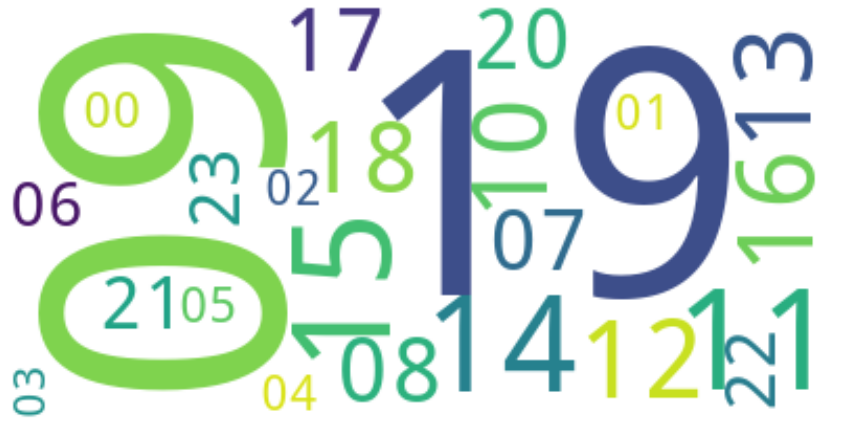

In [108]:
wordcloud = WordCloud(background_color="white").generate_from_frequencies(counts)
plt.figure(figsize=(15,15))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [109]:
wordcloud.to_file("WC_hour-counts.png")